## Idea
+ Architecture
    + FFT
    + Mel scale
    + Conv stack - stride 2
    + Put each channel through the stack
    + Fro each note, divide one channel by the other to get l/r data for each note

In [4]:
from onsets_and_frames import *
import torchaudio as ta

In [5]:
from IPython.display import Audio
from fastprogress.fastprogress import master_bar, progress_bar

In [6]:
from fastai import *
from fastai.vision import *

## Default Values

``` Python
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108
N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048
```

In [7]:
ds = MAESTRO(groups=["2004"], sequence_length=100000, device='cpu')

Loading 1 group of MAESTRO at /home/zach/Data/maestro/maestro-v2.0.0


In [8]:
train_len = int(round(0.8*len(ds)))
train_ds, valid_ds = torch.utils.data.random_split(ds, [train_len, len(ds)-train_len])
train_dl, valid_dl = [DataLoader(ds, batch_size=16, shuffle=True, num_workers=6) for ds in [train_ds, valid_ds]]

### Note
Piano starts at MIDI note 21 and goes to 108 so this dataset will only cover that range

In [9]:
plt.rcParams['figure.figsize'] = 9, 16

In [10]:
ex = next(iter(ds))
ex['label'].shape

torch.Size([195, 88])

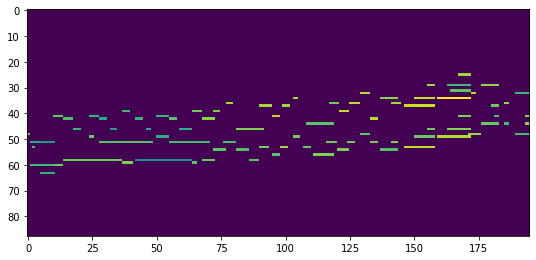

In [11]:
plt.imshow(ex['velocity'].T.flip(0))

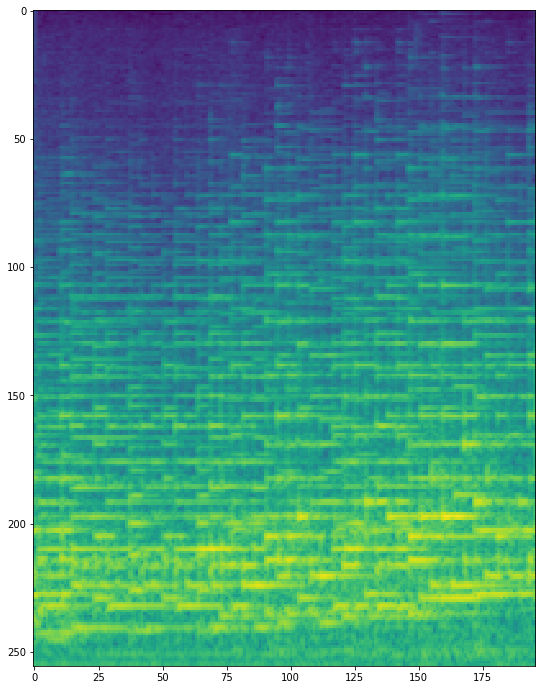

In [13]:
plt.imshow(melspectrogram.cpu()(ex['audio'].unsqueeze(0)).squeeze(0).flip(0))

In [14]:
Audio(ex['audio'].cpu()[:100000], rate=16000)

## Model

In [17]:
def encoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, padding, dilation=1),
        nn.BatchNorm1d(sizes[i][1]),
        nn.ReLU(),
    )

def decoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.ConvTranspose1d(2*sizes[-i+1][1], sizes[-i][1], kernel_size, 2, padding, 1, dilation=1),
        nn.BatchNorm1d(sizes[-i][1]),
        nn.ReLU()
    )

In [19]:
class Audio2Midi(nn.Module):
    def __init__(self, kernel_size):
        super(Audio2Midi, self).__init__()
        sizes = [(256, 64), (128, 128), (64, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        
        self.linear = nn.Linear(128*128, 88)
        self.rnn = nn.GRU(128, 88)
        self.rnn_state = None
        
    def forward(self, x):
        x = self.input(x)
        #print(x.shape)
        for l in self.encoder:
            x = l(x)
            #print(x.shape)
        x = x.flatten(1)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        #x,self.rnn_state = self.rnn(x.unsqueeze(0), self.rnn_state)
        #print(x.shape)
        return F.relu(x).squeeze(0)
    

In [20]:
testnn = Audio2Midi(kernel_size=9)

In [21]:
ex = next(iter(train_dl))
ip_ex = melspectrogram.cpu()(ex['audio']).squeeze(0)
ip_ex.shape

torch.Size([16, 256, 196])

In [22]:
test_output = testnn.forward(ip_ex[:,:,3].unsqueeze(1))
test_output.shape

torch.Size([16, 88])

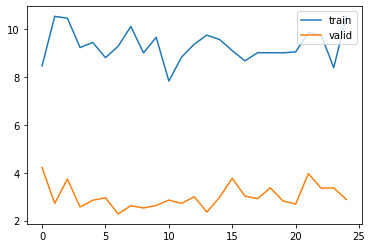

KeyboardInterrupt: 

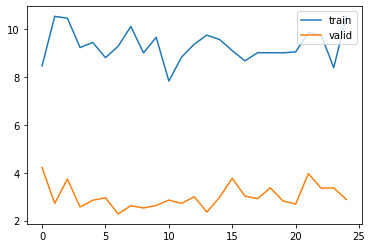

In [24]:
n_epochs = 30

train_ls = []
valid_ls = []

m = Audio2Midi(kernel_size=3).cuda()
m = m.cuda()
optim = torch.optim.Adam(params=m.parameters(), lr=2e-3)
critereon = nn.MSELoss()

mb = master_bar(range(n_epochs))
mb.names = ['train', 'valid']
for e in mb:
    m.train()
    tl = 0
    for it in progress_bar(train_dl, parent=mb):
        audio, target = melspectrogram(it["audio"]), it["velocity"]
        target = target.float()
        m.zero_grad()
        for seg in range(target.shape[2]):
            out = m(audio.cuda()[:,:,seg].unsqueeze(1))
            l = critereon(out, target.cuda()[:,seg,:])
            tl += l.detach().cpu().item()
            l.backward()
            optim.step()
    train_ls.append(tl)
    with torch.no_grad():
        vl = 0
        for it in progress_bar(valid_dl, parent=mb):
            audio, target = melspectrogram(it["audio"]), it["velocity"]
            target = target.float()
            for seg in range(target.shape[2]):
                out = m(audio.cuda()[:,:,seg].unsqueeze(1))
                l = critereon(out, target.cuda()[:,seg,:])
                vl += l.detach().cpu().item()
        valid_ls.append(vl)
    mb.update_graph([[range(e+1), train_ls], [range(e+1), valid_ls]])

In [62]:
next(iter(train_dl))['velocity'].shape

torch.Size([16, 195, 88])